#### Build X and y from Methylation, Expression, Clinical Data

In [98]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [99]:
deg_results = pd.read_csv("diff_exp_results_pairwise.csv")
dmr_results = pd.read_csv("DMPs_All_Comparisons.csv")
clinical_train = pd.read_csv("preprocessed_clinical_train.csv")
clinical_test = pd.read_csv("preprocessed_clinical_test.csv")
gene_expression_data = pd.read_csv("preprocessed_gene_expression.csv", index_col=0)
methylation_data = pd.read_csv("preprocessed_methylation_data.csv", index_col=0)

In [100]:
# Select significant features
deg_sig = deg_results[deg_results["fdr"] < 0.05]["gene"].unique()
dmr_sig = dmr_results["Probe"].unique()

# Extract expression and methylation values
expr_selected = gene_expression_data.loc[deg_sig].T  # rows: samples, columns: genes
meth_selected = methylation_data.loc[dmr_sig].T      # rows: samples, columns: probes

In [101]:
sample_ids = clinical_train['sample'].tolist()

# Split into train (rows in sample_ids) and test (rows not in sample_ids)
train_expr = expr_selected.loc[expr_selected.index.isin(sample_ids)].copy()
test_expr = expr_selected.loc[~expr_selected.index.isin(sample_ids)].copy()

In [102]:
print(train_expr.shape)
print(test_expr.shape)

(612, 2539)
(154, 2539)


In [103]:
# Select training samples for methylation
train_meth = meth_selected.loc[meth_selected.index.isin(sample_ids)].copy()
test_meth = meth_selected.loc[~meth_selected.index.isin(sample_ids)].copy()

In [104]:
print(train_meth.shape)
print(test_meth.shape)

(612, 82)
(154, 82)


In [105]:
clinical_vars = clinical_train[[
    'sample',
    'ajcc_pathologic_stage.diagnoses',
    'ajcc_pathologic_t.diagnoses',
    'ajcc_pathologic_n.diagnoses',
    'ajcc_pathologic_m.diagnoses',
    'primary_diagnosis.diagnoses',
]].copy()

clinical_vars_test = clinical_test[[
    'sample',
    'ajcc_pathologic_stage.diagnoses',
    'ajcc_pathologic_t.diagnoses',
    'ajcc_pathologic_n.diagnoses',
    'ajcc_pathologic_m.diagnoses',
    'primary_diagnosis.diagnoses',
]].copy()

# # One-hot encode all but 'sample'
# clinical_onehot = pd.get_dummies(
#     clinical_vars.set_index("sample"),
#     drop_first=True
# )


In [106]:
# from sklearn.preprocessing import StandardScaler

# age_scaled = pd.DataFrame(
#     StandardScaler().fit_transform(clinical_train[['age_at_index.demographic']]),
#     index=clinical_train['sample'],
#     columns=['age']
# )

In [107]:
# # Merge scaled age and one-hot encoded categorical vars
# clinical_processed = clinical_onehot.join(age_scaled, how='inner')


In [108]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [109]:
# # Remove stage dummies from clinical_processed for feature matrix
# stage_dummy_cols = [col for col in clinical_processed.columns if col.startswith('ajcc_pathologic_stage.diagnoses_')]
# clinical_features = clinical_processed.drop(columns=stage_dummy_cols)

# Build feature matrix X
X_train = train_expr.join(train_meth, how='inner').dropna()

X_test = test_expr.join(test_meth, how='inner').dropna()

# Build target vector y using original stage column
y_train = clinical_vars.set_index("sample") \
                 .loc[X_train.index, 'ajcc_pathologic_stage.diagnoses']

y_test = clinical_vars_test.set_index("sample") \
                 .loc[X_test.index, 'ajcc_pathologic_stage.diagnoses']

In [110]:
feature_names = X_train.columns
print(feature_names)

Index(['ENSG00000000938', 'ENSG00000000971', 'ENSG00000001617',
       'ENSG00000002834', 'ENSG00000003436', 'ENSG00000003989',
       'ENSG00000004399', 'ENSG00000004776', 'ENSG00000004799',
       'ENSG00000005102',
       ...
       'cg18199554', 'cg16118529', 'cg06948435', 'cg16282160', 'cg12828075',
       'cg04726091', 'cg20248516', 'cg19275745', 'cg22500132', 'cg07039149'],
      dtype='object', length=2621)


In [111]:
print(X_train.shape)
print(y_train.shape)

(612, 2621)
(612,)


In [112]:
print(X_test.shape)
print(y_test.shape)

(154, 2621)
(154,)


In [113]:
# Encode multi-class labels to integers
le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

print(le.classes_)

['I' 'II' 'III+IV']


#### Train SVM

In [115]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=200) # Anova F-Test
X_train_reduced = selector.fit_transform(X_train, y_train_enc)
X_test_reduced = selector.transform(X_test)

In [116]:
class_weights = {0: 2.3, 1: 1.0, 2: 2.0}

In [117]:
# Scale features
scaler = StandardScaler() # Mean = 0, Std.dev = 1
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled  = scaler.transform(X_test_reduced)

# Train SVM
clf = SVC(C=0.01, kernel='linear', probability=True, class_weight=class_weights, random_state=42)
clf.fit(X_train_scaled, y_train_enc)

SVC(C=0.01, class_weight={0: 2.3, 1: 1.0, 2: 2.0}, kernel='linear',
    probability=True, random_state=42)

#### Evaluate SVM

ANOVA (Analysis of Variance) F-score measures:
How strongly a feature (e.g., gene expression) differs between classes (e.g., cancer stages) compared to within-class variation.

Mathematically:
𝐹 = variance between groups / variance within groups
​
 
High F-score: The feature has high between-class variance relative to within-class variance. Strongly discriminates between classes.

Low F-score: The feature has similar distributions across classes. Provides little discriminatory power.

In [118]:
# Evaluate
y_pred = clf.predict(X_test_scaled)
report = classification_report(y_test_enc, y_pred, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

           I       0.35      0.52      0.42        25
          II       0.66      0.53      0.59        87
      III+IV       0.38      0.43      0.40        42

    accuracy                           0.50       154
   macro avg       0.46      0.49      0.47       154
weighted avg       0.53      0.50      0.51       154



In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 14,          # base text size
    "axes.titlesize": 16,     # subplot title
    "axes.labelsize": 14,     # axis labels
    "xtick.labelsize": 12,    # x-tick labels
    "ytick.labelsize": 12,    # y-tick labels
    "legend.fontsize": 12,    # legend
    "figure.titlesize": 18    # figure title
})

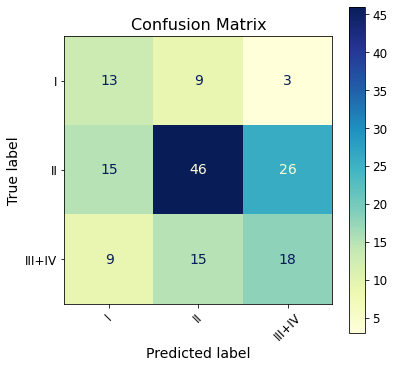

In [120]:
# raw confusion matrix
cm = confusion_matrix(y_test_enc, y_pred)

# Create a ConfusionMatrixDisplay, using label encoder’s classes
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

# Plot with a blue colormap and rotated x-labels
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='YlGnBu', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


#### Cross-validation SVM

In [121]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict

# Build a pipeline
pipeline = Pipeline([
    ("feature_selection", SelectKBest(score_func=f_classif, k=200)),
    ("smote", SMOTE(random_state=42)),
    ("svc", SVC(C=0.01, kernel="linear", class_weight=class_weights,
                 probability=True, random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [122]:
from sklearn.model_selection import GridSearchCV

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters found:
{'svc__C': 0.1}
Best cross-validated macro F1: 0.511

Classification Report (Test Set):
              precision    recall  f1-score   support

           I       0.36      0.64      0.46        25
          II       0.66      0.48      0.56        87
      III+IV       0.43      0.48      0.45        42

    accuracy                           0.51       154
   macro avg       0.48      0.53      0.49       154
weighted avg       0.55      0.51      0.51       154



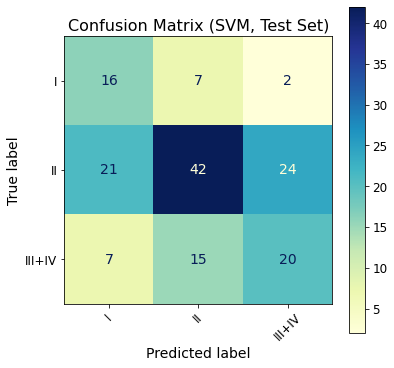

In [123]:
# GridSearchCV setup
param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit on training data only
grid_search.fit(X_train_scaled, y_train_enc)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validated macro F1: {grid_search.best_score_:.3f}")

# Evaluate on test set
y_pred_test = grid_search.best_estimator_.predict(X_test_scaled)

print("\nClassification Report (Test Set):")
print(classification_report(y_test_enc, y_pred_test, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_test_enc, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="YlGnBu", ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix (SVM, Test Set)")
plt.show()


            Feature    F_score
0   ENSG00000103647  13.347142
1   ENSG00000122035  13.235148
2   ENSG00000138722  12.602536
3   ENSG00000089159  12.540894
4        cg08215788  12.258876
5   ENSG00000139679  12.132947
6        cg07196637  11.761461
7        cg15527168  11.745599
8        cg21636683  11.702154
9        cg00207731  11.621317
10       cg23000806  11.566220
11       cg23333915  11.505350
12       cg04576021  11.470114
13  ENSG00000164574  11.426019
14  ENSG00000174348  11.361375
15  ENSG00000177363  11.345802
16  ENSG00000119681  11.248687
17       cg06768599  11.144846
18  ENSG00000256235  11.138725
19       cg16302441  11.092405
20  ENSG00000154721  11.055209
21       cg08928145  10.959869
22       cg04351828  10.954984
23  ENSG00000152583  10.931070
24       cg05854207  10.884405
25  ENSG00000155957  10.832262
26       cg12828075  10.784891
27       cg15359321  10.756195
28  ENSG00000185201  10.734930
29  ENSG00000176435  10.560887


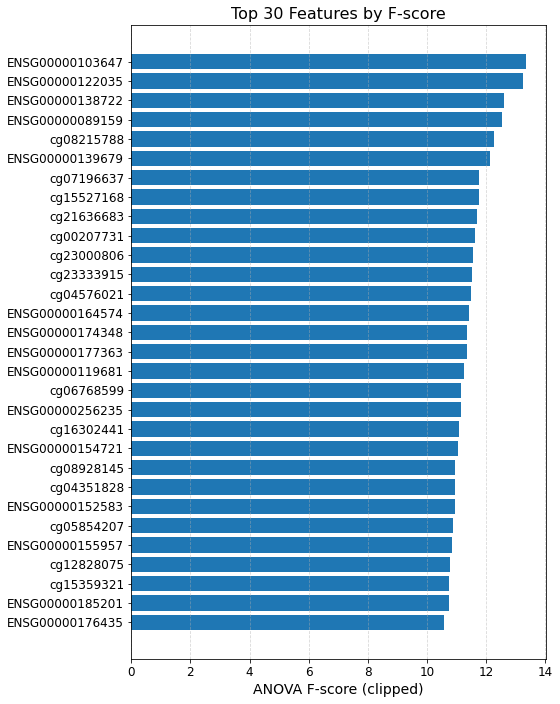

In [124]:
# Access fitted SelectKBest from the tuned pipeline

selector_temp = SelectKBest(score_func=f_classif, k=200)
selector_temp.fit(X_train, y_train_enc)
mask = selector_temp.get_support()
#selector = grid_search.best_estimator_.named_steps['feature_selection']

selected_feature_names = feature_names[mask]

# Retrieve F-scores for selected features
scores = selector_temp.scores_[mask]

# Create DataFrame for easy viewing and annotation
feature_scores_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'F_score': scores
}).sort_values(by='F_score', ascending=False).reset_index(drop=True)

print(feature_scores_df.head(30))


# ============================
# Plot Top 30 Features by F-score
# ============================
top_n = 30
top_features_plot = feature_scores_df.head(top_n).sort_values(by='F_score', ascending=True)

# Clip extremely large values for visualization
max_display_value = 500
plot_scores = top_features_plot['F_score'].clip(upper=max_display_value)

plt.figure(figsize=(8, 10))
plt.barh(top_features_plot['Feature'], plot_scores)
plt.xlabel('ANOVA F-score (clipped)')
plt.title(f'Top {top_n} Features by F-score')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

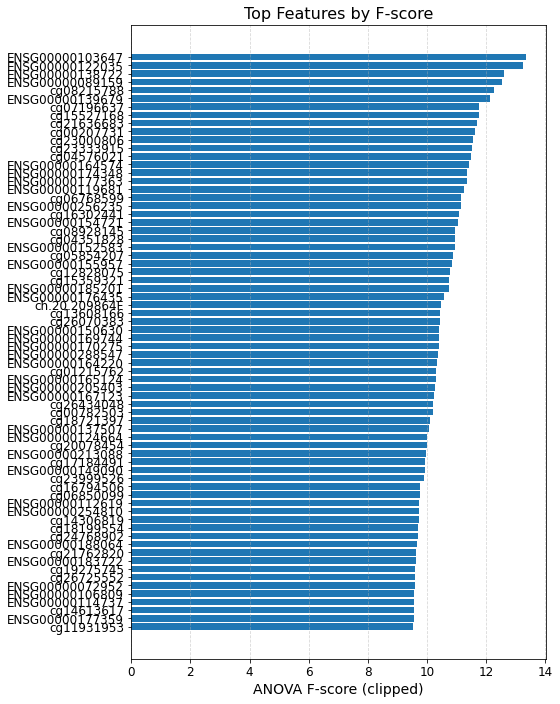

In [125]:
all_features_plot = feature_scores_df.head(70).sort_values(by='F_score', ascending=True)

# Clip extremely large values for visualization
max_display_value = 500
plot_scores = all_features_plot['F_score'].clip(upper=max_display_value)

plt.figure(figsize=(8, 10))
plt.barh(all_features_plot['Feature'], plot_scores)
plt.xlabel('ANOVA F-score (clipped)')
plt.title(f'Top Features by F-score')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [126]:
feature_scores_df.head(30).to_csv("top_30_features_svm.csv", index=False)

CV results:
  accuracy: 0.365 ± 0.048
  precision_macro: 0.385 ± 0.046
  recall_macro: 0.392 ± 0.054
  f1_macro: 0.349 ± 0.048


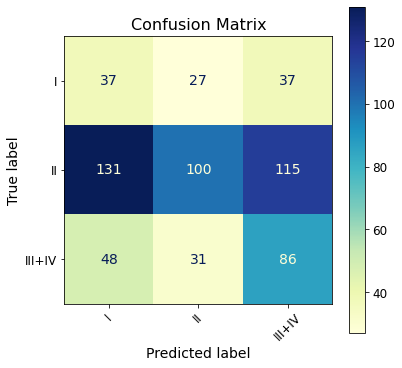


Classification report (CV):
              precision    recall  f1-score   support

           I       0.17      0.37      0.23       101
          II       0.63      0.29      0.40       346
      III+IV       0.36      0.52      0.43       165

    accuracy                           0.36       612
   macro avg       0.39      0.39      0.35       612
weighted avg       0.48      0.36      0.38       612



In [127]:
# Cross‐validate to get accuracy, precision, recall, f1
scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]
cv_results = cross_validate(
    pipeline, 
    X_train, y_train_enc, 
    cv=cv, 
    scoring=scoring,
    return_train_score=False
)
print("CV results:")
for metric in scoring:
    scores = cv_results[f"test_{metric}"]
    print(f"  {metric}: {scores.mean():.3f} ± {scores.std():.3f}")

# Get out-of-fold predictions for every sample
y_pred_cv = cross_val_predict(
    pipeline,
    X_train, y_train_enc, 
    cv=cv, 
    method="predict"
)

# Confusion matrix and classification report on the CV predictions
cm = confusion_matrix(y_train_enc, y_pred_cv)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

# Plot with a blue colormap and rotated x-labels
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='YlGnBu', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print("\nClassification report (CV):")
print(classification_report(y_train_enc, y_pred_cv, target_names=le.classes_))

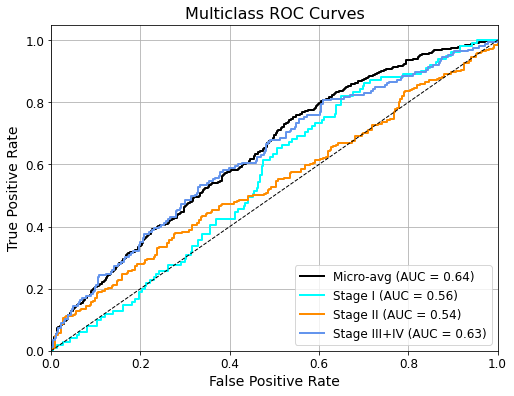

In [128]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
import numpy as np

# Binarize y for multiclass ROC
classes = np.unique(y_train_enc)
y_bin = label_binarize(y_train_enc, classes=classes)

# Get probability estimates via cross‐validated predictions
y_score = cross_val_predict(pipeline, X_train, y_train_enc, cv=cv, method='predict_proba')

# Compute ROC curve and AUC for each class + micro‐average
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro‐avg (AUC = {roc_auc['micro']:.2f})", color="black", lw=2)

colors = ['aqua','darkorange','cornflowerblue','green']
for i, color in enumerate(colors[:len(classes)]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Stage {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim(0,1); plt.ylim(0,1.05)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc='lower right'); plt.grid(True)
plt.show()


#### Train & Evaluate RF

In [129]:
from sklearn.ensemble import RandomForestClassifier

In [130]:
rf_pipeline = Pipeline([
    ("feature_selection", SelectKBest(score_func=f_classif, k=200)),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(class_weight=class_weights, random_state=42))
])

Classification Report (Random Forest, Test Set):
              precision    recall  f1-score   support

           I       0.00      0.00      0.00        25
          II       0.55      0.69      0.61        87
      III+IV       0.36      0.31      0.33        42

    accuracy                           0.47       154
   macro avg       0.30      0.33      0.32       154
weighted avg       0.41      0.47      0.44       154



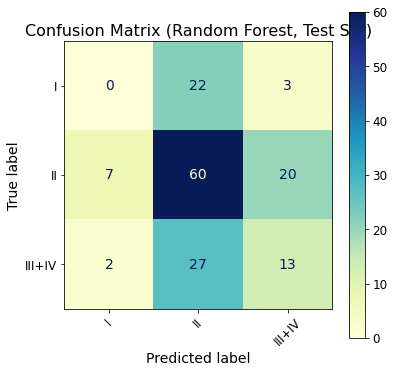

In [131]:
# Fit RF pipeline on all training data
rf_pipeline.fit(X_train_scaled, y_train_enc)

# Predict on test data
y_pred_rf_test = rf_pipeline.predict(X_test_scaled)

# Evaluate
print("Classification Report (Random Forest, Test Set):")
print(classification_report(y_test_enc, y_pred_rf_test, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred_rf_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="YlGnBu", ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix (Random Forest, Test Set)")
plt.show()


In [132]:
param_grid = {
    "rf__n_estimators": [100, 200, 300, 500],
    "rf__max_depth": [None, 10, 20],
    "rf__max_features": ["sqrt", "log2"],
}

# Setup GridSearchCV with StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [133]:
# Fit the model

grid_search_rf.fit(X_train, y_train_enc)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectKBest(k=200)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(class_weight={0: 2.3,
                                                                             1: 1.0,
                                                                             2: 2.0},
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 20],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__n_estimators': [100, 200, 300, 500]},
             scoring='f1_macro', verbose=2)


Classification Report (Random Forest, Test Set):
              precision    recall  f1-score   support

           I       0.14      0.24      0.18        25
          II       0.49      0.36      0.41        87
      III+IV       0.31      0.36      0.33        42

    accuracy                           0.34       154
   macro avg       0.31      0.32      0.31       154
weighted avg       0.38      0.34      0.35       154



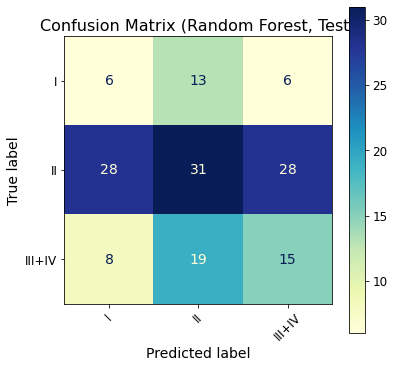

In [134]:
# Fit tuned RF pipeline on all training data
grid_search_rf.best_estimator_.fit(X_train, y_train_enc)

# Predict on test data
y_pred_rf_test = grid_search_rf.best_estimator_.predict(X_test)

# Classification report
print("\nClassification Report (Random Forest, Test Set):")
print(classification_report(y_test_enc, y_pred_rf_test, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_rf_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="YlGnBu", ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix (Random Forest, Test)")
plt.show()



Best Random Forest parameters found:
{'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__n_estimators': 500}
Best cross-validated macro F1: 0.416

Classification Report (Random Forest, CV Predictions):
              precision    recall  f1-score   support

           I       0.22      0.21      0.21       101
          II       0.64      0.61      0.62       346
      III+IV       0.39      0.44      0.41       165

    accuracy                           0.50       612
   macro avg       0.42      0.42      0.42       612
weighted avg       0.50      0.50      0.50       612



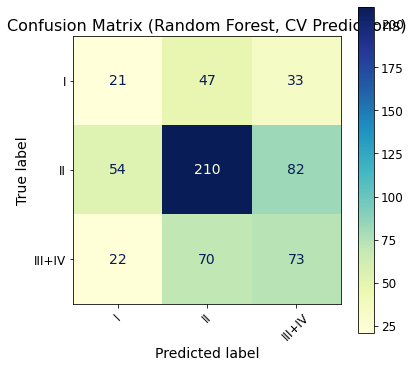

In [135]:
print("\nBest Random Forest parameters found:")
print(grid_search_rf.best_params_)
print(f"Best cross-validated macro F1: {grid_search_rf.best_score_:.3f}")

# Evaluate with cross-validated predictions
y_pred_rf = cross_val_predict(grid_search_rf.best_estimator_, X_train, y_train_enc, cv=cv)

print("\nClassification Report (Random Forest, CV Predictions):")
print(classification_report(y_train_enc, y_pred_rf, target_names=le.classes_, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_train_enc, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="YlGnBu", ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix (Random Forest, CV Predictions)")
plt.show()


Top 30 Features by Random Forest Importance:
            Feature  Importance
0        cg12828075    0.012145
1        cg07196637    0.011574
2        cg23333915    0.011124
3   ENSG00000104691    0.010153
4        cg23749856    0.009960
5   ENSG00000288547    0.009757
6   ENSG00000168078    0.009696
7        cg21762820    0.009553
8   ENSG00000232810    0.009253
9        cg12645891    0.009181
10  ENSG00000188610    0.008209
11       cg24768902    0.008060
12       cg14613617    0.007954
13  ENSG00000158485    0.007764
14       cg24009736    0.007701
15  ENSG00000112619    0.007693
16  ENSG00000165124    0.007532
17       cg01215762    0.007216
18       cg26070383    0.007198
19  ENSG00000205403    0.007180
20       cg16302441    0.007051
21  ENSG00000127533    0.007017
22  ENSG00000236699    0.006871
23       cg06948435    0.006859
24    ch.20.209864F    0.006754
25       cg15527168    0.006735
26  ENSG00000282951    0.006511
27  ENSG00000259124    0.006483
28       cg00207731    0.0

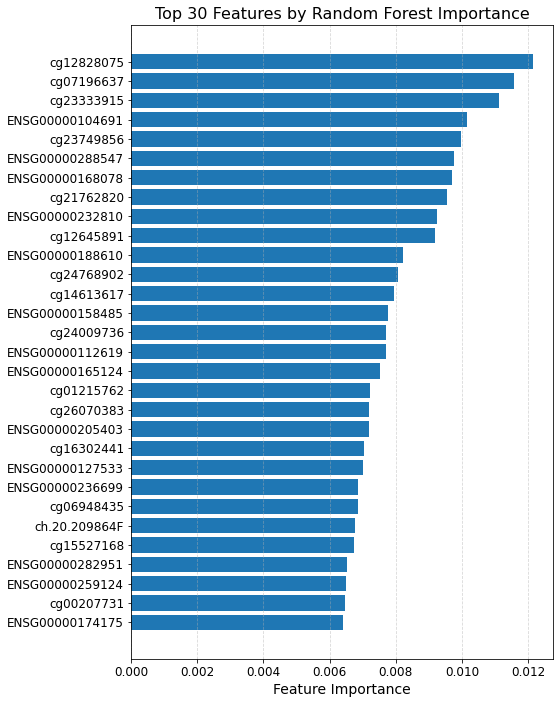

In [136]:
# Feature Importance

# Retrieve SelectKBest feature names
selector_rf = grid_search_rf.best_estimator_.named_steps['feature_selection']
mask_rf = selector_rf.get_support()
selected_features_rf = X_train.columns[mask_rf]

# Retrieve feature importances
rf_model = grid_search_rf.best_estimator_.named_steps['rf']
importances = rf_model.feature_importances_

# Create DataFrame for top features
feature_importances_df = pd.DataFrame({
    'Feature': selected_features_rf,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("\nTop 30 Features by Random Forest Importance:")
print(feature_importances_df.head(30))

# Plot top 30 feature importances
top_n = 30
top_features_rf = feature_importances_df.head(top_n).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 10))
plt.barh(top_features_rf['Feature'], top_features_rf['Importance'])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Features by Random Forest Importance')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [137]:
feature_importances_df.head(30).to_csv("top_30_features_rf.csv")

#### Train & Evaluate Logistic Regression

In [138]:
from sklearn.linear_model import LogisticRegression

In [139]:
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),    
    ("feature_selection", SelectKBest(score_func=f_classif, k=200)),
    ("smote", SMOTE(random_state=42)),
    ("logreg", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",         # efficient for multinomial
        class_weight="balanced",
        max_iter=500,
        random_state=42
    ))
])

In [140]:
param_grid = {
    "logreg__C": [0.001, 0.01, 0.1, 1, 10],   # inverse regularization strength
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_logreg = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2
)


Fitting 5 folds for each of 5 candidates, totalling 25 fits

Classification Report (Logistic Regression, Test Set):
              precision    recall  f1-score   support

           I       0.22      0.40      0.28        25
          II       0.58      0.38      0.46        87
      III+IV       0.31      0.38      0.34        42

    accuracy                           0.38       154
   macro avg       0.37      0.39      0.36       154
weighted avg       0.45      0.38      0.40       154



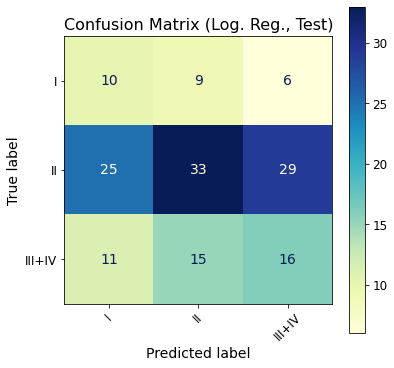

In [141]:
grid_search_logreg.fit(X_train, y_train_enc)

grid_search_logreg.best_estimator_.fit(X_train, y_train_enc)

# Predict on test data
y_pred_logreg_test = grid_search_logreg.best_estimator_.predict(X_test)

# Classification report
print("\nClassification Report (Logistic Regression, Test Set):")
print(classification_report(y_test_enc, y_pred_logreg_test, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_logreg_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="YlGnBu", ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix (Log. Reg., Test)")
plt.show()


Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Logistic Regression parameters found:
{'logreg__C': 0.001}
Best cross-validated macro F1: 0.438

Classification Report (Logistic Regression, CV Predictions):
              precision    recall  f1-score   support

           I       0.22      0.30      0.26       101
          II       0.68      0.51      0.59       346
      III+IV       0.43      0.56      0.49       165

    accuracy                           0.49       612
   macro avg       0.45      0.46      0.44       612
weighted avg       0.54      0.49      0.51       612



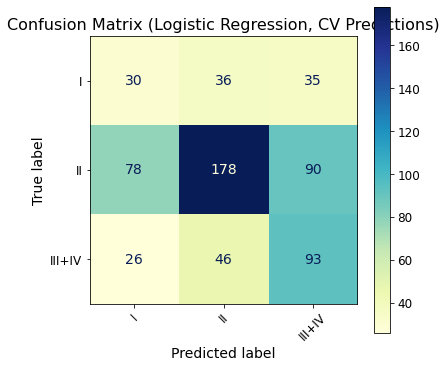

In [142]:
# Fit the model
grid_search_logreg.fit(X_train, y_train_enc)

print("\nBest Logistic Regression parameters found:")
print(grid_search_logreg.best_params_)
print(f"Best cross-validated macro F1: {grid_search_logreg.best_score_:.3f}")

# Evaluate with cross-validated predictions
y_pred_logreg = cross_val_predict(grid_search_logreg.best_estimator_, X_train, y_train_enc, cv=cv)

print("\nClassification Report (Logistic Regression, CV Predictions):")
print(classification_report(y_train_enc, y_pred_logreg, target_names=le.classes_, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_train_enc, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="YlGnBu", ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix (Logistic Regression, CV Predictions)")
plt.show()


Top 30 Features by Mean Absolute Coefficient (Logistic Regression):
            Feature  MeanAbsCoefficient
0        cg14613617            0.035499
1   ENSG00000288547            0.035453
2   ENSG00000222041            0.034453
3   ENSG00000112619            0.034035
4        cg07196637            0.033710
5   ENSG00000282951            0.033307
6     ch.20.209864F            0.032381
7   ENSG00000158485            0.031853
8   ENSG00000227620            0.030887
9        cg24768902            0.030052
10  ENSG00000139194            0.028737
11  ENSG00000262098            0.028676
12       cg23333915            0.028404
13       cg04726091            0.026732
14       cg12828075            0.026590
15       cg15359321            0.026404
16  ENSG00000168078            0.025694
17  ENSG00000232386            0.025382
18       cg06132853            0.024109
19  ENSG00000105613            0.023975
20       cg16282160            0.023898
21  ENSG00000127533            0.023716
22       cg

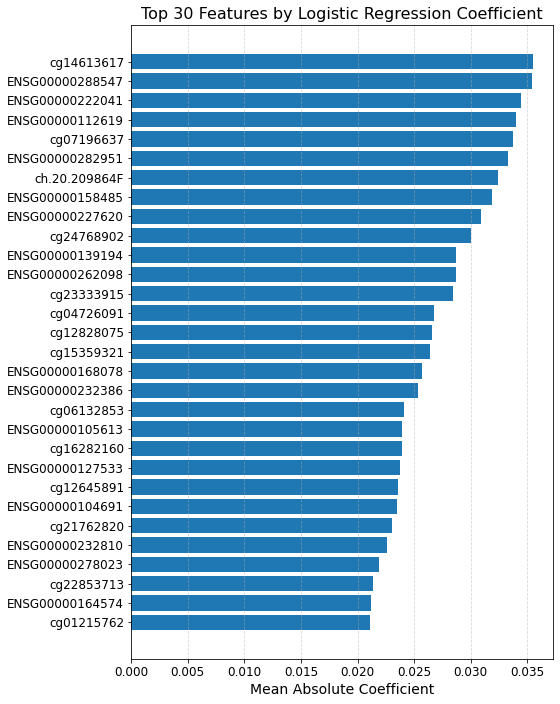

In [143]:
# Retrieve and view top coefficients
# Access fitted SelectKBest from the tuned pipeline
selector_logreg = grid_search_logreg.best_estimator_.named_steps['feature_selection']
mask_logreg = selector_logreg.get_support()
selected_features_logreg = X_train.columns[mask_logreg]

# Retrieve coefficients
logreg_model = grid_search_logreg.best_estimator_.named_steps['logreg']
coefficients = logreg_model.coef_  # shape: (n_classes, n_features)

# Compute mean absolute coefficient across classes for ranking
mean_abs_coef = np.mean(np.abs(coefficients), axis=0)

coef_df = pd.DataFrame({
    'Feature': selected_features_logreg,
    'MeanAbsCoefficient': mean_abs_coef
}).sort_values(by='MeanAbsCoefficient', ascending=False).reset_index(drop=True)

print("\nTop 30 Features by Mean Absolute Coefficient (Logistic Regression):")
print(coef_df.head(30))

# Plot top 30 feature coefficients
top_n = 30
top_features_logreg = coef_df.head(top_n).sort_values(by='MeanAbsCoefficient', ascending=True)

plt.figure(figsize=(8, 10))
plt.barh(top_features_logreg['Feature'], top_features_logreg['MeanAbsCoefficient'])
plt.xlabel('Mean Absolute Coefficient')
plt.title(f'Top {top_n} Features by Logistic Regression Coefficient')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [144]:
coef_df.head(30).to_csv("top_30_features_logistic_regression.csv", index=False)

In [145]:
from collections import defaultdict

In [ ]:
# Create mapping of feature -> (score, model)
feature_to_models_scores = {
    'genes': defaultdict(lambda: {'models': set(), 'score': None}),
    'sites': defaultdict(lambda: {'models': set(), 'score': None}),
    'clinical': defaultdict(lambda: {'models': set(), 'score': None})
}

# Helper to categorize features
def categorize_feature(feat):
    if feat.startswith('ENSG'):
        return 'genes'
    elif feat.startswith('cg'):
        return 'sites'
    else:
        return 'clinical'

top_n = 20

# Add SVM top features + scores
for _, row in feature_scores_df.head(top_n).iterrows():
    feat = row['Feature']
    score = row['F_score']
    category = categorize_feature(feat)
    feature_to_models_scores[category][feat]['models'].add('SVM')
    feature_to_models_scores[category][feat]['score'] = score

# Add Random Forest top features + scores
for _, row in feature_importances_df.head(top_n).iterrows():
    feat = row['Feature']
    score = row['Importance']
    category = categorize_feature(feat)
    feature_to_models_scores[category][feat]['models'].add('Random Forest')
    feature_to_models_scores[category][feat]['score'] = score

# Add Logistic Regression top features + scores
for _, row in coef_df.head(top_n).iterrows():
    feat = row['Feature']
    score = row['MeanAbsCoefficient']
    category = categorize_feature(feat)
    feature_to_models_scores[category][feat]['models'].add('Logistic Regression')
    feature_to_models_scores[category][feat]['score'] = score

# Convert to DataFrames
dfs = {}
for category, fmap in feature_to_models_scores.items():
    df = pd.DataFrame({
        f"{category[:-1].capitalize()} Name": list(fmap.keys()),
        "Model Name": [", ".join(sorted(entry['models'])) for entry in fmap.values()],
        "Score": [entry['score'] for entry in fmap.values()]
    }).sort_values(by="Score", ascending=False).reset_index(drop=True)
    dfs[category] = df

genes_df = dfs['genes']
sites_df = dfs['sites']
#clinical_df = dfs['clinical']

# Output CSVs
genes_df.to_csv("top_genes_combined_with_scores.csv", index=False)
sites_df.to_csv("top_sites_combined_with_scores.csv", index=False)
#clinical_df.to_csv("top_clinical_combined_with_scores.csv", index=False)

# Display for quick inspection
print("Top Genes:\n", genes_df.head(10), "\n")
print("Top Sites:\n", sites_df.head(10), "\n")
#print("Top Clinical:\n", clinical_df.head(10))


Top Genes:
          Gene Name Model Name      Score
0  ENSG00000103647        SVM  13.347142
1  ENSG00000122035        SVM  13.235148
2  ENSG00000138722        SVM  12.602536
3  ENSG00000089159        SVM  12.540894
4  ENSG00000139679        SVM  12.132947
5  ENSG00000164574        SVM  11.426019
6  ENSG00000174348        SVM  11.361375
7  ENSG00000177363        SVM  11.345802
8  ENSG00000119681        SVM  11.248687
9  ENSG00000256235        SVM  11.138725 

Top Sites:
     Site Name                               Model Name      Score
0  cg08215788                                      SVM  12.258876
1  cg15527168                                      SVM  11.745599
2  cg21636683                                      SVM  11.702154
3  cg00207731                                      SVM  11.621317
4  cg23000806                                      SVM  11.566220
5  cg04576021                                      SVM  11.470114
6  cg06768599                                      SVM  11.14

#### Comparison of the Methods

Macro metrics are sensitive to class imbalance. If your model performs poorly on a rare class (like Stage IV in our case), macro scores will reflect that more clearly than micro or weighted metrics.

Macro precision = average of all class-wise precisions.
Macro recall = average of all class-wise recalls.
Equal weight is given to each class

In [147]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_metrics(y_true, y_pred, average="macro"):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average=average, zero_division=0),
        "recall": recall_score(y_true, y_pred, average=average, zero_division=0),
        "f1": f1_score(y_true, y_pred, average=average, zero_division=0)
    }

In [148]:
# Retrieve predictions for each model
y_pred_svm = cross_val_predict(grid_search.best_estimator_, X_train, y_train_enc, cv=cv)
y_pred_rf = cross_val_predict(grid_search_rf.best_estimator_, X_train, y_train_enc, cv=cv)
y_pred_logreg = cross_val_predict(grid_search_logreg.best_estimator_, X_train, y_train_enc, cv=cv)

# Collect metrics
metrics_svm = get_metrics(y_train_enc, y_pred_svm)
metrics_rf = get_metrics(y_train_enc, y_pred_rf)
metrics_logreg = get_metrics(y_train_enc, y_pred_logreg)

# Assemble into DataFrame
metrics_df = pd.DataFrame([metrics_svm, metrics_rf, metrics_logreg],
                          index=["SVM", "Random Forest", "Logistic Regression"])
print(metrics_df)

                     accuracy  precision    recall        f1
SVM                  0.390523   0.365406  0.370718  0.356544
Random Forest        0.496732   0.415665  0.419094  0.416597
Logistic Regression  0.491830   0.445034  0.458372  0.442806


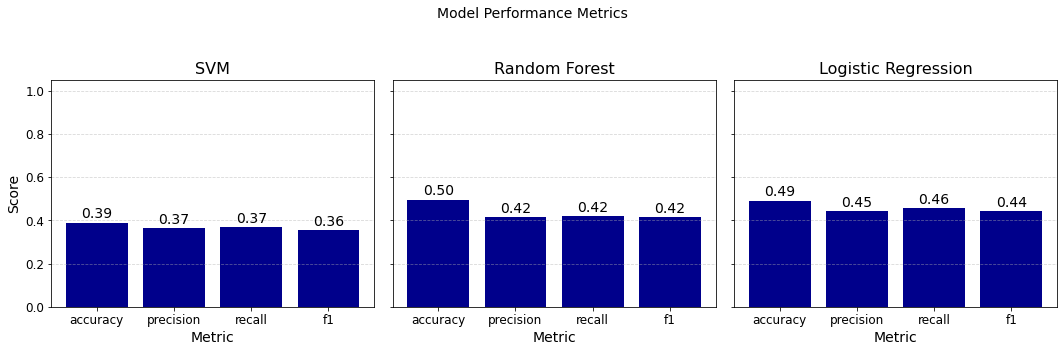

In [149]:
# Set up figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Loop through models and axes
for ax, (model_name, scores) in zip(axes, metrics_df.iterrows()):
    ax.bar(scores.index, scores.values, color='darkblue')
    ax.set_title(f"{model_name}")
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score" if model_name == "SVM" else "")
    ax.set_xlabel("Metric")
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    # Add numeric labels
    for i, v in enumerate(scores.values):
        ax.text(i, v + 0.02, f"{v:.2f}", ha='center')

# Global figure title
fig.suptitle("Model Performance Metrics", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


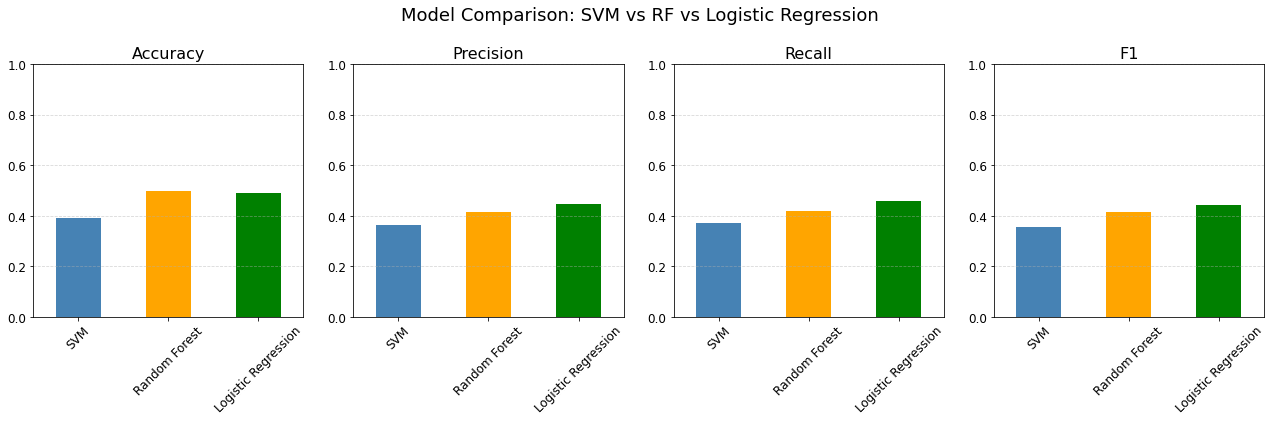

In [150]:
metrics_to_plot = ["accuracy", "precision", "recall", "f1"]

fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for ax, metric in zip(axes, metrics_to_plot):
    metrics_df[metric].plot(kind="bar", ax=ax, color=["steelblue", "orange", "green"])
    ax.set_title(metric.capitalize())
    ax.set_ylim(0, 1)
    ax.set_xticklabels(metrics_df.index, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle("Model Comparison: SVM vs RF vs Logistic Regression")
plt.tight_layout()
plt.show()

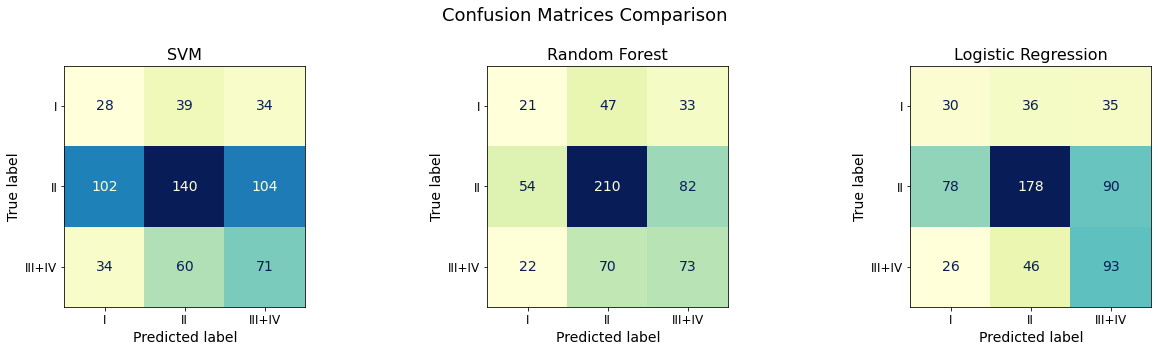

In [151]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# SVM
cm_svm = confusion_matrix(y_train_enc, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=le.classes_)
disp_svm.plot(ax=axes[0], cmap='YlGnBu', colorbar=False)
axes[0].set_title("SVM")

# Random Forest
cm_rf = confusion_matrix(y_train_enc, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_)
disp_rf.plot(ax=axes[1], cmap='YlGnBu', colorbar=False)
axes[1].set_title("Random Forest")

# Logistic Regression
cm_logreg = confusion_matrix(y_train_enc, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=le.classes_)
disp_logreg.plot(ax=axes[2], cmap='YlGnBu', colorbar=False)
axes[2].set_title("Logistic Regression")

plt.suptitle("Confusion Matrices Comparison")
plt.tight_layout()
plt.show()

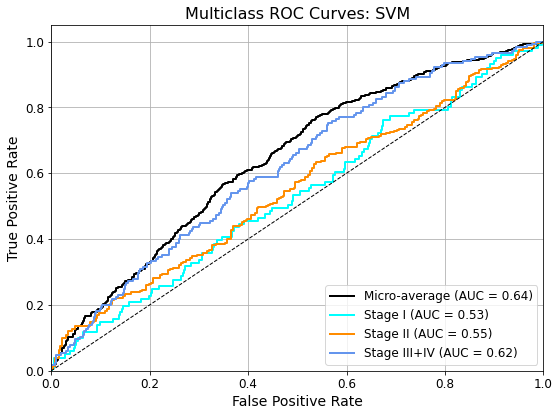

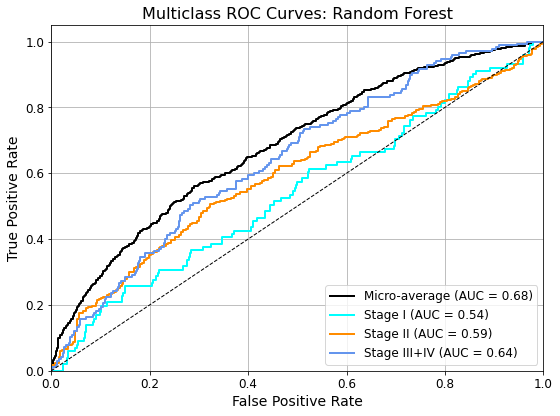

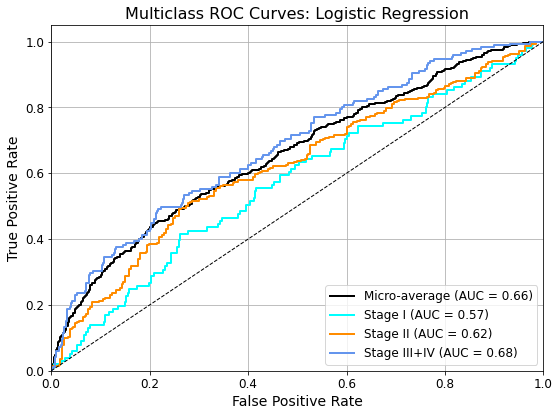

In [152]:
# Function to plot ROC for a given model and title
def plot_roc(model, model_name):
    y_score = cross_val_predict(
        model, X_train, y_train_enc, cv=cv, method='predict_proba', n_jobs=-1, verbose=0
    )

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
             color="black", lw=2)

    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
    for i, color in enumerate(colors[:len(classes)]):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"Stage {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Multiclass ROC Curves: {model_name}")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for SVM
plot_roc(grid_search.best_estimator_, "SVM")

# Plot for Random Forest
plot_roc(grid_search_rf.best_estimator_, "Random Forest")

# Plot for Logistic Regression
plot_roc(grid_search_logreg.best_estimator_, "Logistic Regression")

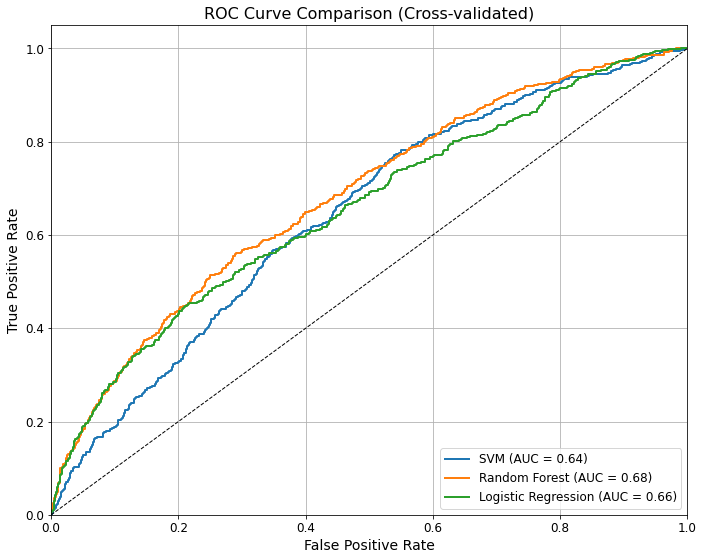

In [153]:
# Prepare binary labels for ROC calculation
y_bin = label_binarize(y_train_enc, classes=np.unique(y_train_enc))
classes = np.unique(y_train_enc)

# Function to get micro-average ROC data
def get_micro_roc(model):
    y_score = cross_val_predict(
        model, X_train, y_train_enc, cv=cv, method='predict_proba', n_jobs=-1, verbose=0
    )
    fpr, tpr, _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

models = {
    "SVM": grid_search.best_estimator_,
    "Random Forest": grid_search_rf.best_estimator_,
    "Logistic Regression": grid_search_logreg.best_estimator_
}

# Plot combined ROC curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    fpr, tpr, roc_auc = get_micro_roc(model)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve Comparison (Cross-validated)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


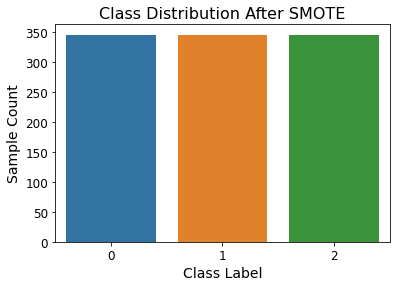

In [154]:
# Inspect SMOTE
import seaborn as sns

# Step-by-step preprocessing (up to SMOTE)
X_scaled = StandardScaler().fit_transform(X_train)
X_selected = SelectKBest(score_func=f_classif, k=200).fit_transform(X_scaled, y_train_enc)

# Apply SMOTE manually
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_selected, y_train_enc)

# Visualize class distribution
sns.countplot(x=y_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.show()


C:\Users\igali\AppData\Local\Temp\ipykernel_8740\3220534861.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(test_metrics_df.index, rotation=45)
C:\Users\igali\AppData\Local\Temp\ipykernel_8740\3220534861.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(test_metrics_df.index, rotation=45)
C:\Users\igali\AppData\Local\Temp\ipykernel_8740\3220534861.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(test_metrics_df.index, rotation=45)
C:\Users\igali\AppData\Local\Temp\ipykernel_8740\3220534861.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(test_metrics_df.index, rotation=45)


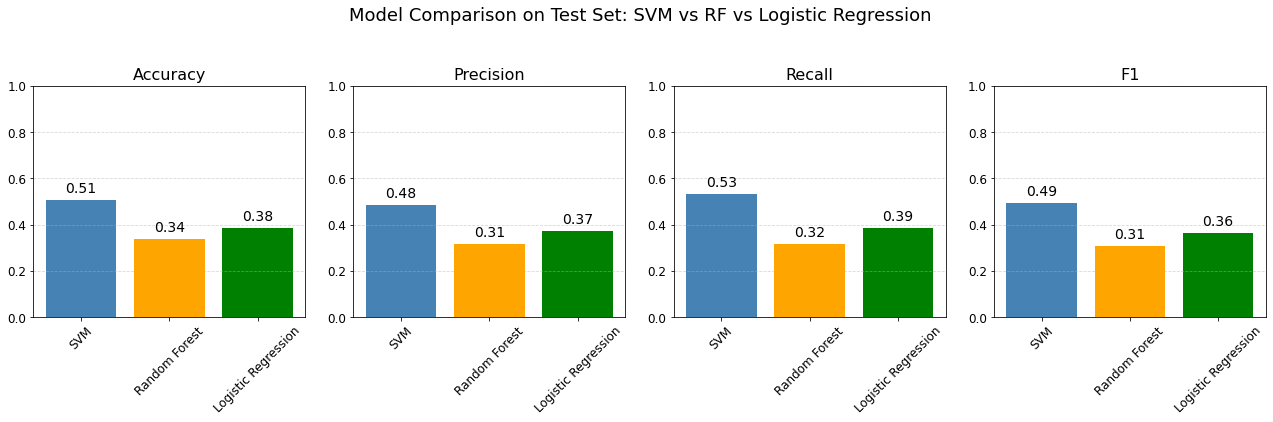

In [155]:
# Compute test set metrics for each model
metrics_svm = get_metrics(y_test_enc, y_pred_test)
metrics_rf = get_metrics(y_test_enc, y_pred_rf_test)
metrics_logreg = get_metrics(y_test_enc, y_pred_logreg_test)

# Assemble into DataFrame
test_metrics_df = pd.DataFrame(
    [metrics_svm, metrics_rf, metrics_logreg],
    index=["SVM", "Random Forest", "Logistic Regression"]
)

# Plotting
metrics_to_plot = ["accuracy", "precision", "recall", "f1"]
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for ax, metric in zip(axes, metrics_to_plot):
    bars = ax.bar(test_metrics_df.index, test_metrics_df[metric], color=["steelblue", "orange", "green"])
    ax.set_title(metric.capitalize())
    ax.set_ylim(0, 1)
    ax.set_xticklabels(test_metrics_df.index, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    # Add numeric labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}", ha='center', va='bottom')

plt.suptitle("Model Comparison on Test Set: SVM vs RF vs Logistic Regression")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [156]:

# 1. Binarize true labels for micro-average ROC
y_test_bin = label_binarize(y_test_enc, classes=range(len(le.classes_)))

# 2. Extract just the classifier steps (trained on 200 features)
svc = grid_search.best_estimator_.named_steps['svc']
rf  = grid_search_rf.best_estimator_.named_steps['rf']
lr  = grid_search_logreg.best_estimator_.named_steps['logreg']

# 3. Predict probabilities using already-scaled & selected X_test_scaled
y_score_svm = svc.predict_proba(X_test_scaled)
y_score_rf  = rf.predict_proba(X_test_scaled)
y_score_lr  = lr.predict_proba(X_test_scaled)

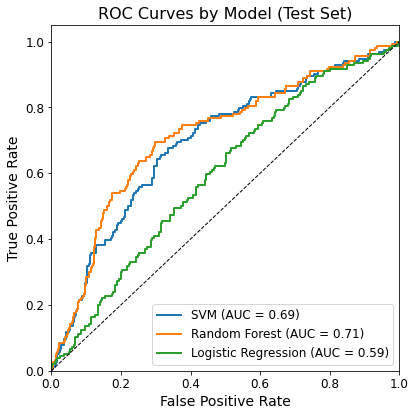

In [157]:
# 4. Compute micro-average ROC for each model
models = {
    "SVM": y_score_svm,
    "Random Forest": y_score_rf,
    "Logistic Regression": y_score_lr
}

plt.figure(figsize=(6, 6))
for name, y_score in models.items():
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

# 5. Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# 6. Labels and aesthetics
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Model (Test Set)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()